In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import StratifiedKFold, train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (accuracy_score, classification_report, confusion_matrix, roc_auc_score,
                              roc_curve, precision_recall_curve)

Dataset loaded successfully!

Dataset shape: (768, 9)
Target distribution:
outcome
0    500
1    268
Name: count, dtype: int64


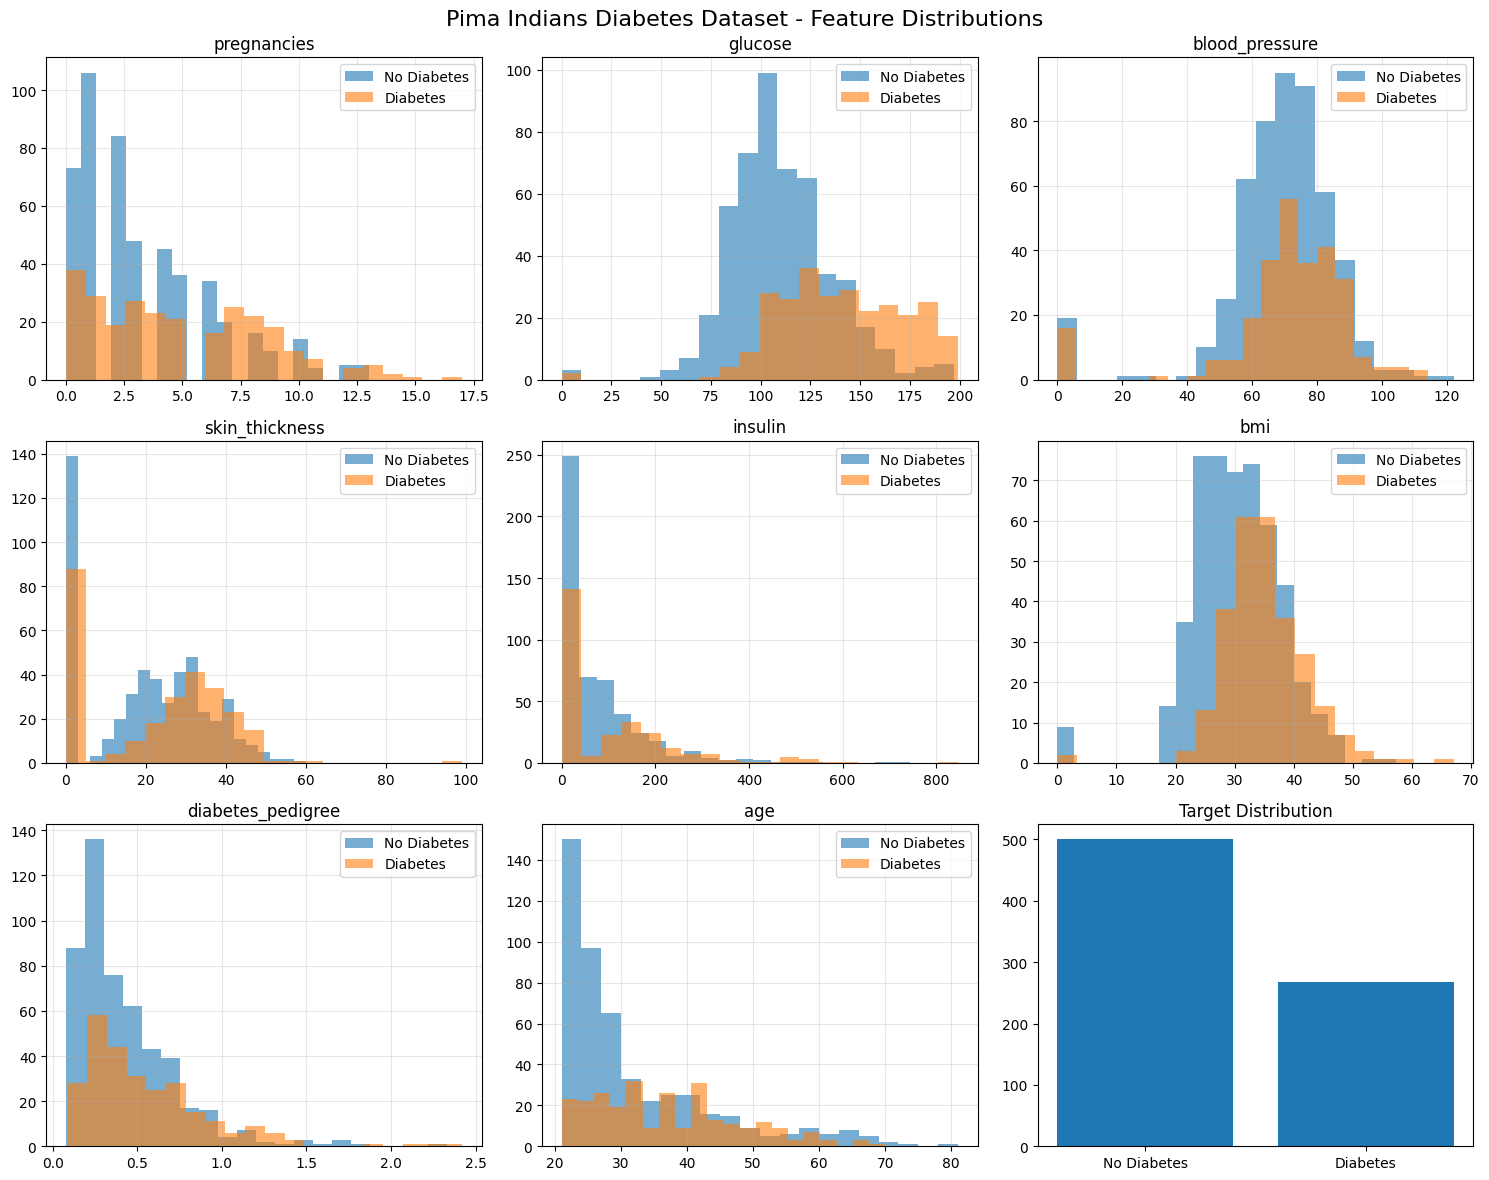

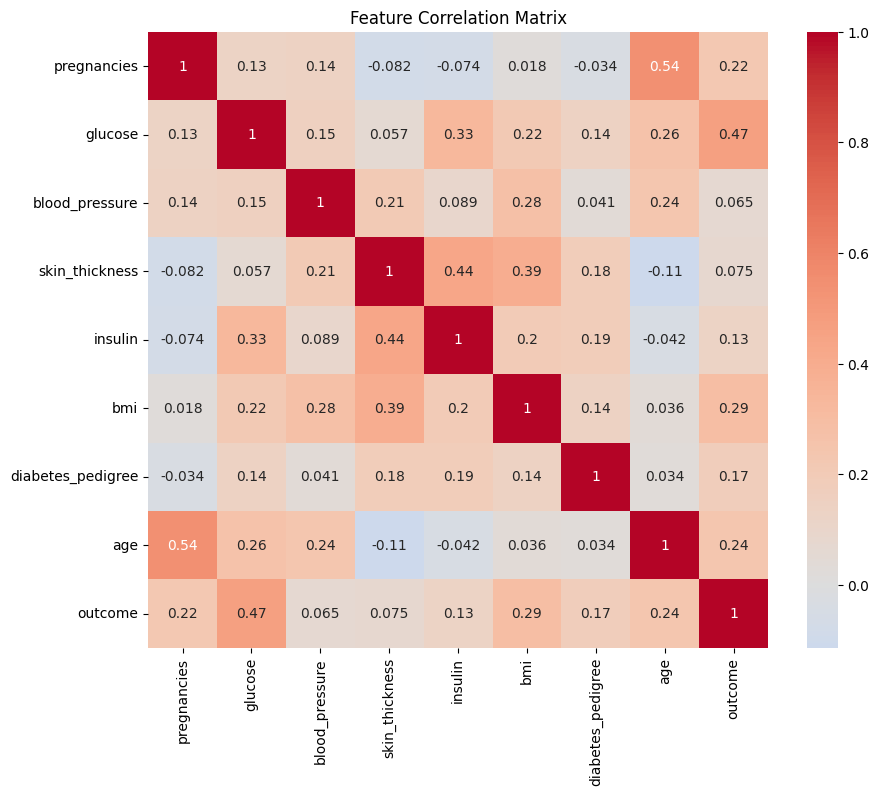


EVALUATING LOGISTIC L1


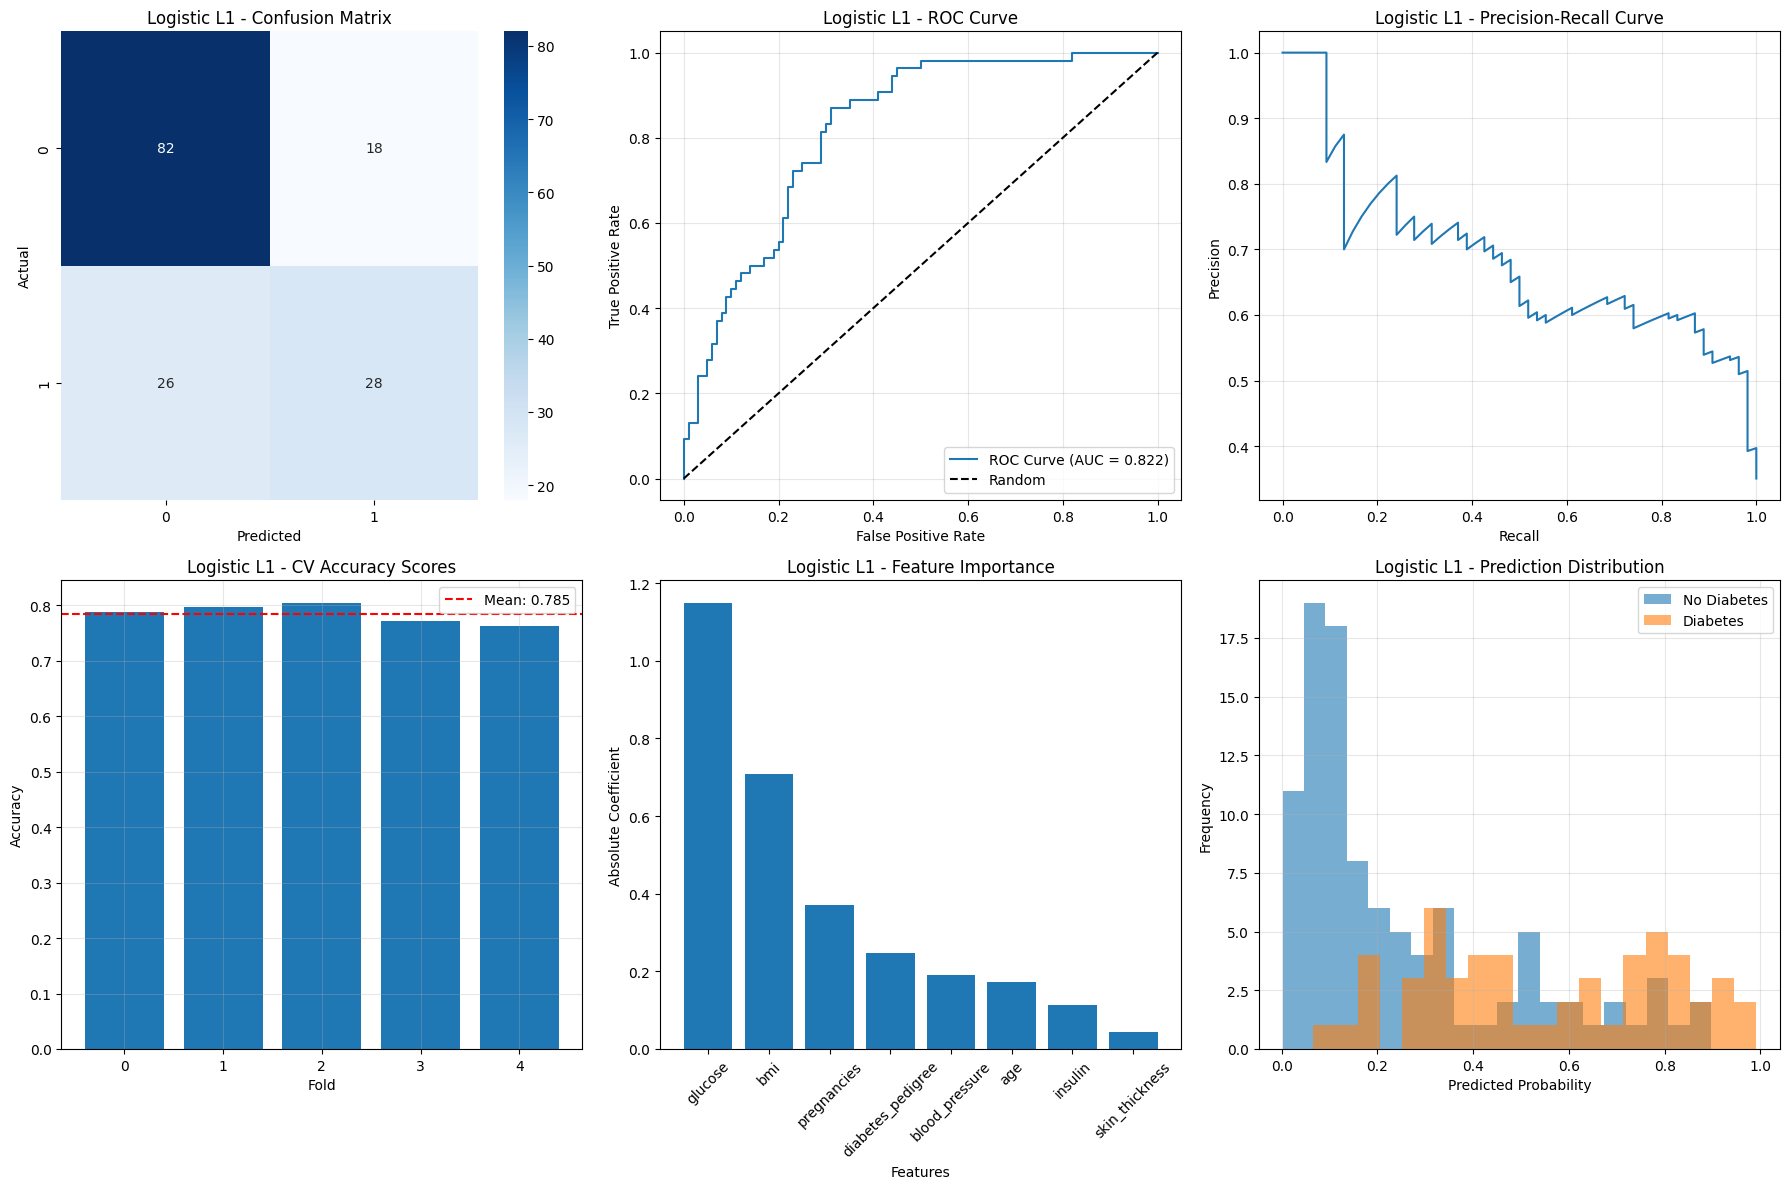

Train Accuracy: 0.7932
Test Accuracy: 0.7143
Precision: 0.6087
Recall: 0.5185
F1-Score: 0.5600
ROC-AUC: 0.8217
CV Accuracy Mean: 0.7850
CV Accuracy Std: 0.0156
CV F1 Mean: 0.6525
CV ROC-AUC Mean: 0.8332

Classification Report:
              precision    recall  f1-score   support

           0       0.76      0.82      0.79       100
           1       0.61      0.52      0.56        54

    accuracy                           0.71       154
   macro avg       0.68      0.67      0.67       154
weighted avg       0.71      0.71      0.71       154


EVALUATING LOGISTIC L2


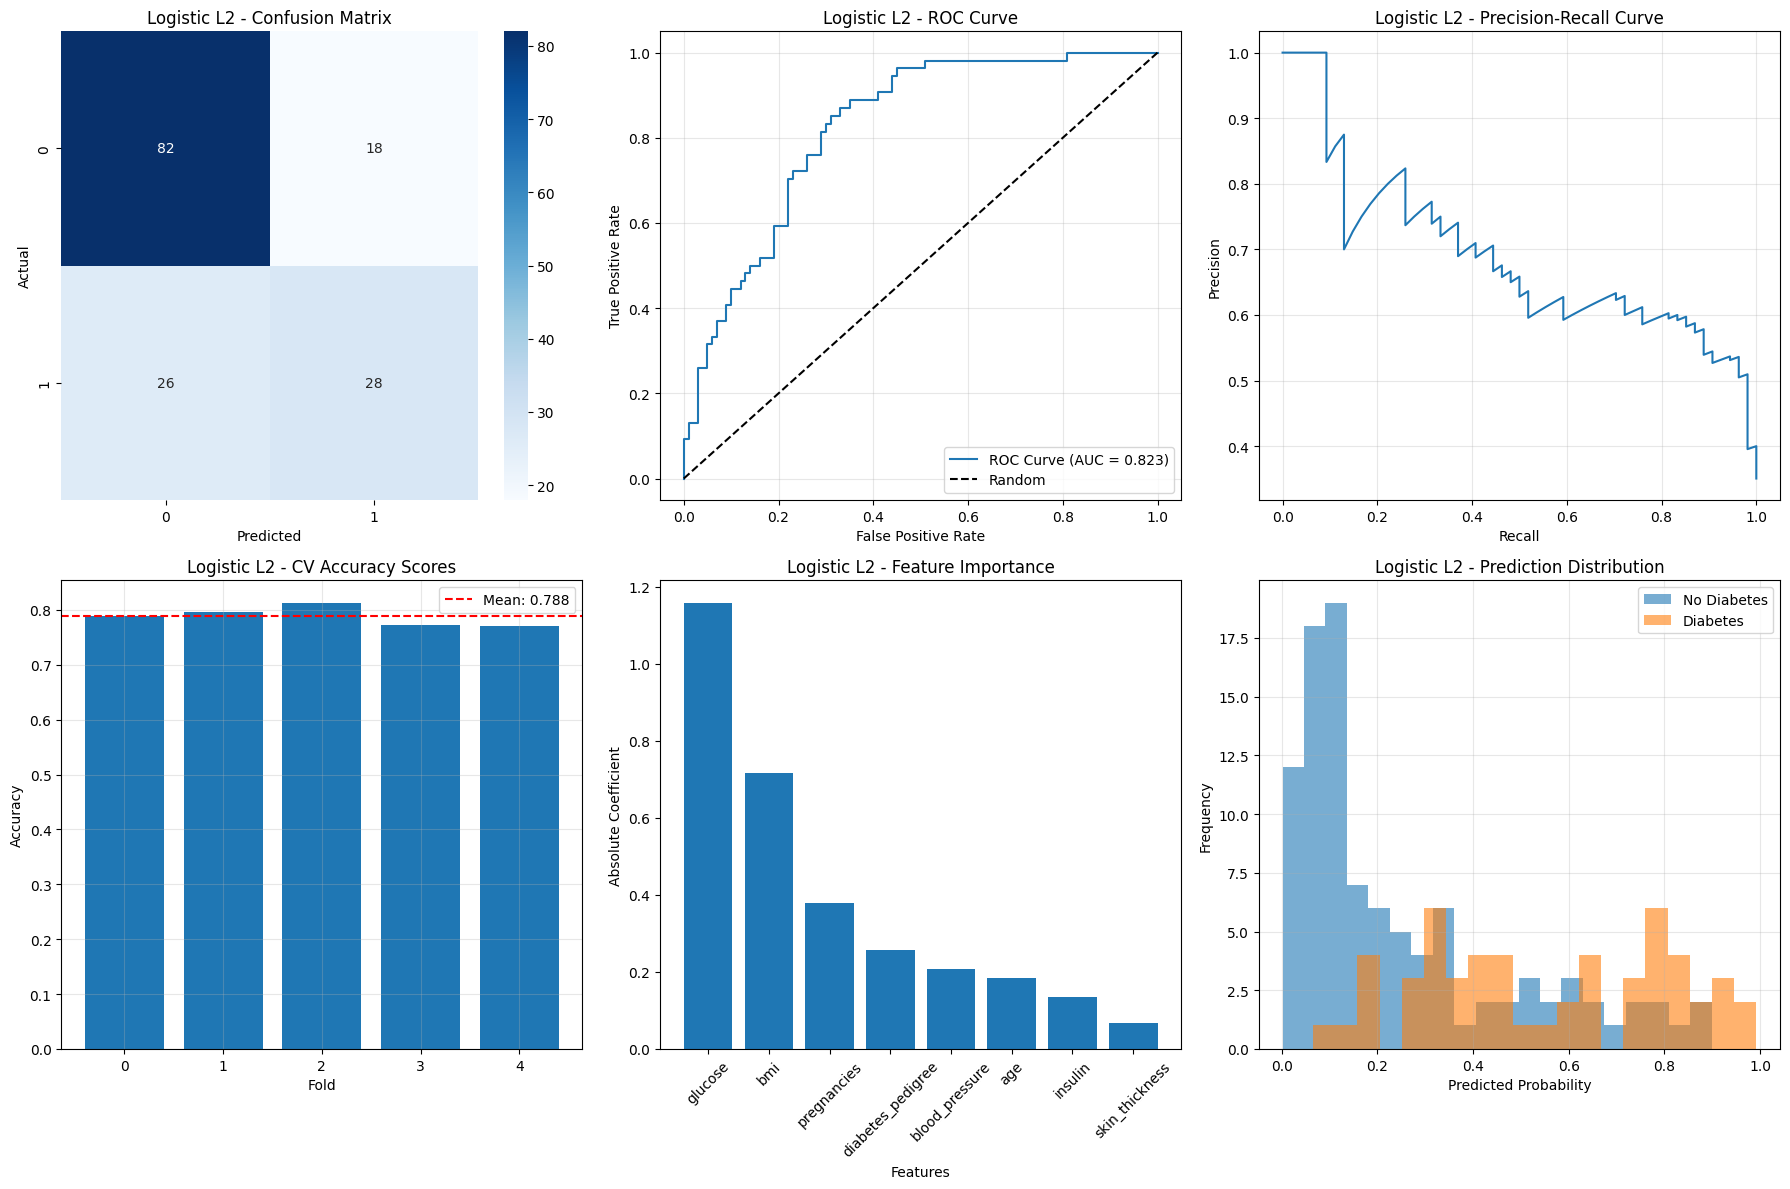

Train Accuracy: 0.7915
Test Accuracy: 0.7143
Precision: 0.6087
Recall: 0.5185
F1-Score: 0.5600
ROC-AUC: 0.8230
CV Accuracy Mean: 0.7882
CV Accuracy Std: 0.0158
CV F1 Mean: 0.6579
CV ROC-AUC Mean: 0.8335

Classification Report:
              precision    recall  f1-score   support

           0       0.76      0.82      0.79       100
           1       0.61      0.52      0.56        54

    accuracy                           0.71       154
   macro avg       0.68      0.67      0.67       154
weighted avg       0.71      0.71      0.71       154


EVALUATING LOGISTIC ELASTIC NET


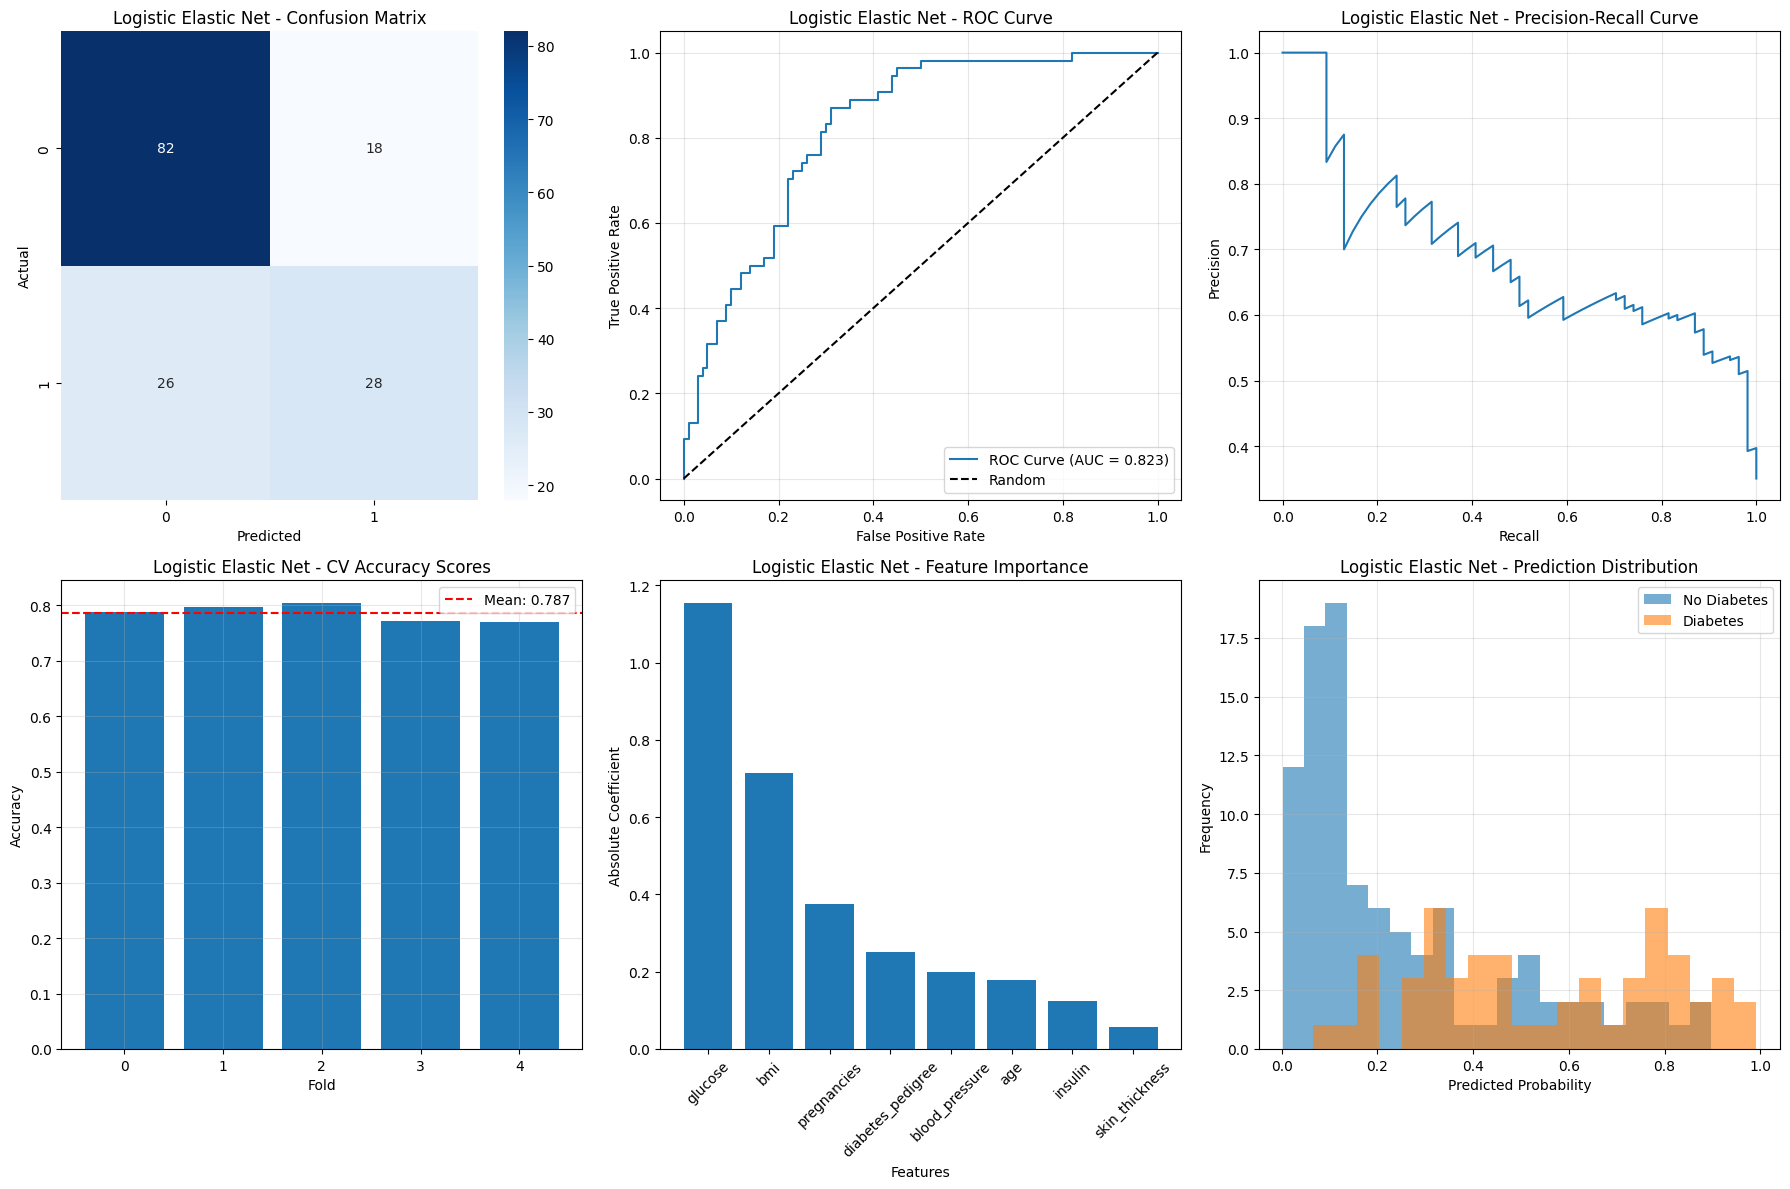

Train Accuracy: 0.7915
Test Accuracy: 0.7143
Precision: 0.6087
Recall: 0.5185
F1-Score: 0.5600
ROC-AUC: 0.8231
CV Accuracy Mean: 0.7866
CV Accuracy Std: 0.0134
CV F1 Mean: 0.6560
CV ROC-AUC Mean: 0.8338

Classification Report:
              precision    recall  f1-score   support

           0       0.76      0.82      0.79       100
           1       0.61      0.52      0.56        54

    accuracy                           0.71       154
   macro avg       0.68      0.67      0.67       154
weighted avg       0.71      0.71      0.71       154


MODEL COMPARISON
                      Train Accuracy  Test Accuracy  Precision  Recall  \
Logistic L1                   0.7932         0.7143     0.6087  0.5185   
Logistic L2                   0.7915         0.7143     0.6087  0.5185   
Logistic Elastic Net          0.7915         0.7143     0.6087  0.5185   

                      F1-Score  ROC-AUC  CV Accuracy Mean  CV Accuracy Std  \
Logistic L1               0.56   0.8217            0.

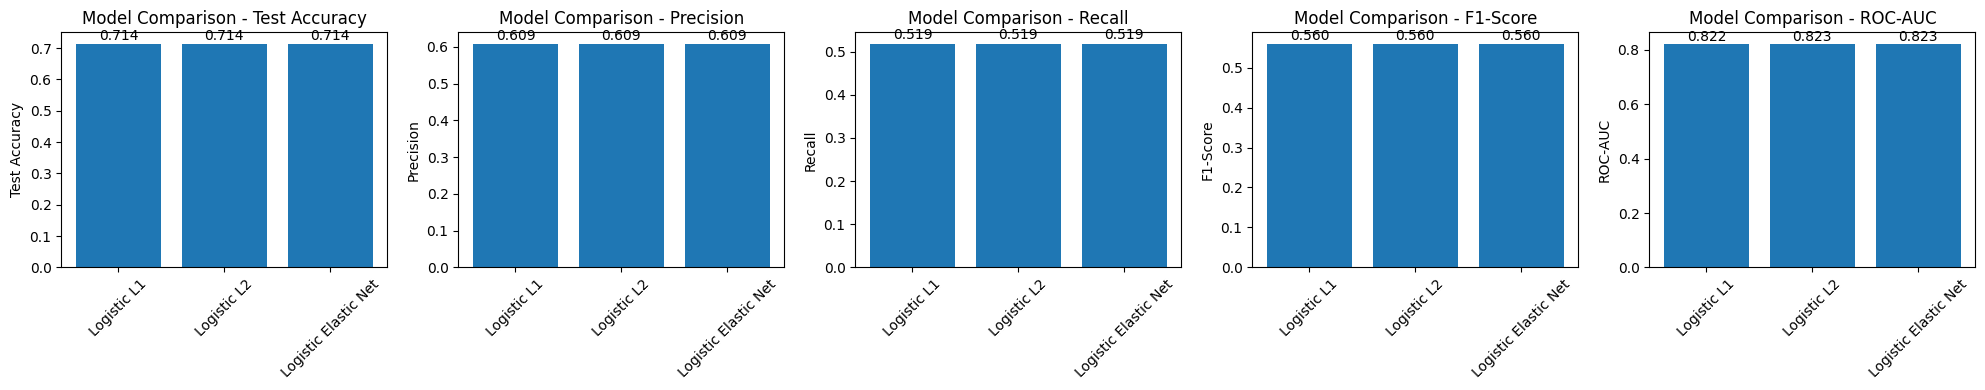

In [2]:
url = "https://raw.githubusercontent.com/jbrownlee/Datasets/master/pima-indians-diabetes.data.csv"
columns = ['pregnancies', 'glucose', 'blood_pressure', 'skin_thickness', 
           'insulin', 'bmi', 'diabetes_pedigree', 'age', 'outcome']

try:
    df = pd.read_csv(url, names=columns)
    print("Dataset loaded successfully!")
except:
    from sklearn.datasets import make_classification
    X_temp, y_temp = make_classification(n_samples=768, n_features=8, n_classes=2, 
                                        n_informative=6, random_state=42)
    df = pd.DataFrame(X_temp, columns=columns[:-1])
    df['outcome'] = y_temp
    print("Using synthetic diabetes-like data")

print(f"\nDataset shape: {df.shape}")
print(f"Target distribution:\n{df['outcome'].value_counts()}")

fig, axes = plt.subplots(3, 3, figsize=(15, 12))
fig.suptitle('Pima Indians Diabetes Dataset - Feature Distributions', fontsize=16)

for i, feature in enumerate(columns[:-1]):
    row, col = i // 3, i % 3

    df[df['outcome'] == 0][feature].hist(bins=20, alpha=0.6, label='No Diabetes', ax=axes[row, col])
    df[df['outcome'] == 1][feature].hist(bins=20, alpha=0.6, label='Diabetes', ax=axes[row, col])
    axes[row, col].set_title(feature)
    axes[row, col].legend()
    axes[row, col].grid(True, alpha=0.3)


axes[2, 2].bar(['No Diabetes', 'Diabetes'], df['outcome'].value_counts().values)
axes[2, 2].set_title('Target Distribution')

plt.tight_layout()
plt.show()


plt.figure(figsize=(10, 8))
sns.heatmap(df.corr(), annot=True, cmap='coolwarm', center=0)
plt.title('Feature Correlation Matrix')
plt.show()


X = df.drop('outcome', axis=1)
y = df['outcome']


scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, 
                                                    random_state=42, stratify=y)

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

models = {
    'Logistic L1': LogisticRegression(penalty='l1', solver='liblinear', C=1.0, random_state=42),
    'Logistic L2': LogisticRegression(penalty='l2', C=1.0, random_state=42),
    'Logistic Elastic Net': LogisticRegression(penalty='elasticnet', solver='saga', 
                                             C=1.0, l1_ratio=0.5, random_state=42)
}

def evaluate_classification_model(model, X_train, X_test, y_train, y_test, cv, model_name):
    
    model.fit(X_train, y_train)
    
    y_pred_train = model.predict(X_train)
    y_pred_test = model.predict(X_test)
    y_pred_proba = model.predict_proba(X_test)[:, 1]
    
    cv_scores = cross_val_score(model, X_train, y_train, cv=cv, scoring='accuracy')
    cv_f1 = cross_val_score(model, X_train, y_train, cv=cv, scoring='f1')
    cv_roc_auc = cross_val_score(model, X_train, y_train, cv=cv, scoring='roc_auc')
    
    train_acc = accuracy_score(y_train, y_pred_train)
    test_acc = accuracy_score(y_test, y_pred_test)
    
    report = classification_report(y_test, y_pred_test, output_dict=True)
    
    metrics = {
        'Train Accuracy': train_acc,
        'Test Accuracy': test_acc,
        'Precision': report['1']['precision'],
        'Recall': report['1']['recall'],
        'F1-Score': report['1']['f1-score'],
        'ROC-AUC': roc_auc_score(y_test, y_pred_proba),
        'CV Accuracy Mean': cv_scores.mean(),
        'CV Accuracy Std': cv_scores.std(),
        'CV F1 Mean': cv_f1.mean(),
        'CV ROC-AUC Mean': cv_roc_auc.mean()
    }
    
    fig, axes = plt.subplots(2, 3, figsize=(18, 12))
    
    cm = confusion_matrix(y_test, y_pred_test)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[0, 0])
    axes[0, 0].set_title(f'{model_name} - Confusion Matrix')
    axes[0, 0].set_xlabel('Predicted')
    axes[0, 0].set_ylabel('Actual')
    
    fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
    axes[0, 1].plot(fpr, tpr, label=f'ROC Curve (AUC = {roc_auc_score(y_test, y_pred_proba):.3f})')
    axes[0, 1].plot([0, 1], [0, 1], 'k--', label='Random')
    axes[0, 1].set_xlabel('False Positive Rate')
    axes[0, 1].set_ylabel('True Positive Rate')
    axes[0, 1].set_title(f'{model_name} - ROC Curve')
    axes[0, 1].legend()
    axes[0, 1].grid(True, alpha=0.3)
    
    precision, recall, _ = precision_recall_curve(y_test, y_pred_proba)
    axes[0, 2].plot(recall, precision)
    axes[0, 2].set_xlabel('Recall')
    axes[0, 2].set_ylabel('Precision')
    axes[0, 2].set_title(f'{model_name} - Precision-Recall Curve')
    axes[0, 2].grid(True, alpha=0.3)
    
    axes[1, 0].bar(range(len(cv_scores)), cv_scores)
    axes[1, 0].axhline(y=cv_scores.mean(), color='r', linestyle='--', 
                      label=f'Mean: {cv_scores.mean():.3f}')
    axes[1, 0].set_xlabel('Fold')
    axes[1, 0].set_ylabel('Accuracy')
    axes[1, 0].set_title(f'{model_name} - CV Accuracy Scores')
    axes[1, 0].legend()
    axes[1, 0].grid(True, alpha=0.3)
    
    if hasattr(model, 'coef_'):
        feature_importance = abs(model.coef_[0])
        feature_names = columns[:-1]
        indices = np.argsort(feature_importance)[::-1]
        axes[1, 1].bar(range(len(feature_importance)), feature_importance[indices])
        axes[1, 1].set_xlabel('Features')
        axes[1, 1].set_ylabel('Absolute Coefficient')
        axes[1, 1].set_title(f'{model_name} - Feature Importance')
        axes[1, 1].set_xticks(range(len(feature_names)))
        axes[1, 1].set_xticklabels([feature_names[i] for i in indices], rotation=45)
    
    axes[1, 2].hist(y_pred_proba[y_test == 0], bins=20, alpha=0.6, label='No Diabetes')
    axes[1, 2].hist(y_pred_proba[y_test == 1], bins=20, alpha=0.6, label='Diabetes')
    axes[1, 2].set_xlabel('Predicted Probability')
    axes[1, 2].set_ylabel('Frequency')
    axes[1, 2].set_title(f'{model_name} - Prediction Distribution')
    axes[1, 2].legend()
    axes[1, 2].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    return metrics, report


results = {}
reports = {}

for name, model in models.items():
    print(f"\n{'='*60}")
    print(f"EVALUATING {name.upper()}")
    print('='*60)
    
    metrics, report = evaluate_classification_model(model, X_train, X_test, y_train, y_test, skf, name)
    results[name] = metrics
    reports[name] = report
    
    for metric_name, value in metrics.items():
        print(f"{metric_name}: {value:.4f}")
    
    print(f"\nClassification Report:")
    print(classification_report(y_test, model.predict(X_test)))


comparison_df = pd.DataFrame(results).T
print(f"\n{'='*60}")
print("MODEL COMPARISON")
print('='*60)
print(comparison_df.round(4))


metrics_to_compare = ['Test Accuracy', 'Precision', 'Recall', 'F1-Score', 'ROC-AUC']
fig, axes = plt.subplots(1, len(metrics_to_compare), figsize=(20, 4))

for i, metric in enumerate(metrics_to_compare):
    values = [results[name][metric] for name in models.keys()]
    axes[i].bar(models.keys(), values)
    axes[i].set_title(f'Model Comparison - {metric}')
    axes[i].set_ylabel(metric)
    axes[i].tick_params(axis='x', rotation=45)
    for j, v in enumerate(values):
        axes[i].text(j, v + 0.01, f'{v:.3f}', ha='center')

plt.tight_layout()
plt.show()